In [1]:
from pyspark.sql import SparkSession, types

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate()
spark

your 131072x1 screen size is bogus. expect trouble
25/04/05 17:34:28 WARN Utils: Your hostname, Trydex resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/05 17:34:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/05 17:34:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_green = spark.read.parquet("../datasets/pq/green/*/*")
df_green.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: integer (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [3]:
df_green.rdd.getNumPartitions()

19

In [4]:
rdd = df_green \
    .select('lpep_pickup_datetime', 'PULocationID', 'total_amount') \
    .rdd
rdd.take(10)

[Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 11, 4, 5, 54), PULocationID=129, total_amount=8.51),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 7, 19, 34, 40), PULocationID=82, total_amount=8.8),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 15, 19, 7, 7), PULocationID=75, total_amount=8.76),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 27, 17, 26, 4), PULocationID=210, total_amount=11.44),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 19, 12, 18, 31), PULocationID=129, total_amount=5.8),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 22, 19, 43, 11), PULocationID=65, total_amount=26.55),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 7, 13, 39), PULocationID=82, total_amount=18.94),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 14, 17, 55, 4), PULocationID=260, total_amount=11.3),
 Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 24, 8, 16), PULocationID=59, total_amount=23.58),
 Row(lpep_pickup_datetime=datetime.datetime(2020

In [5]:
from datetime import datetime

start = datetime(year=2021,month=1,day=1)

In [6]:
def filter_outliers(row):
    return row.lpep_pickup_datetime >= start

In [7]:
# Applying filter
rdd.filter(filter_outliers).take(1)

[Row(lpep_pickup_datetime=datetime.datetime(2021, 10, 29, 13, 51, 40), PULocationID=166, total_amount=15.3)]

In [8]:
# Extract a row
row = rdd.take(1)[0]
row

Row(lpep_pickup_datetime=datetime.datetime(2020, 1, 11, 4, 5, 54), PULocationID=129, total_amount=8.51)

In [9]:
# This is the equivalent of groupBy but performing on RDD level
# Performing map() to create key value pairs

def prepare_for_grouping(row): 
    # Create a key
    hour = row.lpep_pickup_datetime.replace(minute=0, second=0, microsecond=0)
    zone = row.PULocationID
    key = (hour, zone) # Composite Key
    
    # Create value
    amount = row.total_amount
    count = 1
    value = (amount, count) # Composite Value

    return (key, value) # Returns a tuple

prepare_for_grouping(row)

((datetime.datetime(2020, 1, 11, 4, 0), 129), (8.51, 1))

In [10]:
# Map Phase
"""
Creates key value pairs for aggregation via map()
"""
print("{key, value}")
print("((hour, zone), (amount, count))")
rdd \
    .filter(filter_outliers) \
    .map(prepare_for_grouping) \
    .take(10)

{key, value}
((hour, zone), (amount, count))


[((datetime.datetime(2021, 10, 29, 13, 0), 166), (15.3, 1)),
 ((datetime.datetime(2021, 10, 19, 10, 0), 188), (18.5, 1)),
 ((datetime.datetime(2021, 10, 14, 8, 0), 75), (9.3, 1)),
 ((datetime.datetime(2021, 10, 14, 2, 0), 264), (18.36, 1)),
 ((datetime.datetime(2021, 10, 8, 23, 0), 82), (12.25, 1)),
 ((datetime.datetime(2021, 10, 26, 16, 0), 95), (12.3, 1)),
 ((datetime.datetime(2021, 10, 18, 9, 0), 7), (21.96, 1)),
 ((datetime.datetime(2021, 10, 18, 12, 0), 75), (7.8, 1)),
 ((datetime.datetime(2021, 10, 17, 10, 0), 35), (23.98, 1)),
 ((datetime.datetime(2021, 10, 9, 16, 0), 19), (48.11, 1))]

In [11]:
# This is the equivalent of groupBy but performing on RDD level
# Performing reduce() to collect values of like keys together (via reduceByKey for local aggregation)

# Take 2 tuples with like keys
# (K1, V1), (K1, V2)
# left_value = V1, right_value = V2
def calculate_revenue(left_value, right_value):
    # left  => V1 = (amount, count)
    # right => V2 = (amount, count)
    left_amount, left_count = left_value # amount
    right_amount, right_count = right_value # count
    
    output_amount = left_amount + right_amount # add amount of the same key
    output_count = left_count + right_count # add count of the same key
    
    return (output_amount, output_count)

In [12]:
# Reduce Phase
"""
Perform local aggreagation (sum) on keys via reduceByKey()
"""
print("{key, value}")
print("((hour, zone), (amount, count))")

rdd \
    .filter(filter_outliers) \
    .map(prepare_for_grouping) \
    .reduceByKey(calculate_revenue) \
    .take(10)

{key, value}
((hour, zone), (amount, count))


[((datetime.datetime(2021, 10, 16, 7, 0), 174), (162.04000000000002, 3)),
 ((datetime.datetime(2021, 10, 29, 14, 0), 7), (312.9, 14)),
 ((datetime.datetime(2021, 10, 5, 8, 0), 152), (120.87, 5)),
 ((datetime.datetime(2021, 10, 14, 15, 0), 166), (271.59000000000003, 12)),
 ((datetime.datetime(2021, 10, 13, 14, 0), 42), (109.07, 6)),
 ((datetime.datetime(2021, 10, 20, 21, 0), 95), (37.739999999999995, 3)),
 ((datetime.datetime(2021, 10, 28, 10, 0), 75), (515.07, 28)),
 ((datetime.datetime(2021, 10, 29, 20, 0), 74), (244.71999999999997, 15)),
 ((datetime.datetime(2021, 10, 10, 7, 0), 69), (58.04, 1)),
 ((datetime.datetime(2021, 10, 3, 18, 0), 42), (131.51999999999998, 5))]

In [13]:
# Create an immutable named tuple instead of using a fully fledged class
from collections import namedtuple

RevenueRow = namedtuple('RevenueRow',['hour','zone','revenue','count'])

# Utility function
def unwrap(row):
    return RevenueRow(
        hour=row[0][0], 
        zone=row[0][1],
        revenue=row[1][0],
        count=row[1][1]
    )

In [14]:
# Unwrapping each row and converting rdd back to spark DF
results_df = rdd \
    .filter(filter_outliers) \
    .map(prepare_for_grouping) \
    .reduceByKey(calculate_revenue) \
    .map(unwrap) \
    .toDF()
results_df.show(10)

+-------------------+----+------------------+-----+
|               hour|zone|           revenue|count|
+-------------------+----+------------------+-----+
|2021-10-16 07:00:00| 174|162.04000000000002|    3|
|2021-10-29 14:00:00|   7|             312.9|   14|
|2021-10-05 08:00:00| 152|            120.87|    5|
|2021-10-14 15:00:00| 166|271.59000000000003|   12|
|2021-10-13 14:00:00|  42|            109.07|    6|
|2021-10-20 21:00:00|  95|37.739999999999995|    3|
|2021-10-28 10:00:00|  75|            515.07|   28|
|2021-10-29 20:00:00|  74|244.71999999999997|   15|
|2021-10-10 07:00:00|  69|             58.04|    1|
|2021-10-03 18:00:00|  42|131.51999999999998|    5|
+-------------------+----+------------------+-----+
only showing top 10 rows



In [15]:
# Automatically inferred schema
results_df.printSchema()

root
 |-- hour: timestamp (nullable = true)
 |-- zone: long (nullable = true)
 |-- revenue: double (nullable = true)
 |-- count: long (nullable = true)



In [16]:
# Supply a schema
result_schema = types.StructType([
    types.StructField('hour', types.TimestampType(), True),
    types.StructField('zone', types.IntegerType(), True),
    types.StructField('revenue', types.DoubleType(), True),
    types.StructField('count', types.IntegerType(), True)
])

In [17]:
# Apply schema
results_df = (
    rdd
    .filter(filter_outliers)           # Remove rows with revenue/count outliers
    .map(prepare_for_grouping)         # Convert row into (key, value) for aggregation
    .reduceByKey(calculate_revenue)    # Combine values by key to calculate revenue
    .map(unwrap)                       # Convert (key, value) back to Row
    .toDF(result_schema)               # Convert RDD[Row] to DataFrame
)

results_df.printSchema()

root
 |-- hour: timestamp (nullable = true)
 |-- zone: integer (nullable = true)
 |-- revenue: double (nullable = true)
 |-- count: integer (nullable = true)



In [18]:
# Save as parquet file
results_df.write.parquet('../datasets/tmp/green-revenue', mode='overwrite')

25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
25/04/05 17:34:51 WARN MemoryManager: Total allocation exceeds 95.

## **Map Partitions**

In [19]:
# Select desired columns
columns = ['VendorID', 'lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance']

# Convert spark df into rdd
duration_rdd = (
    df_green
    .select(columns)
    .rdd
)

duration_rdd.take(5)

[Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2020, 1, 11, 4, 5, 54), PULocationID=129, DOLocationID=129, trip_distance=0.81),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2020, 1, 7, 19, 34, 40), PULocationID=82, DOLocationID=56, trip_distance=1.25),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2020, 1, 15, 19, 7, 7), PULocationID=75, DOLocationID=75, trip_distance=0.88),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2020, 1, 27, 17, 26, 4), PULocationID=210, DOLocationID=108, trip_distance=1.52),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2020, 1, 19, 12, 18, 31), PULocationID=129, DOLocationID=129, trip_distance=0.58)]

In [20]:
import pandas as pd

# Load rdd as a pandas df
row = duration_rdd.take(10)
df = pd.DataFrame(row,columns=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   VendorID              10 non-null     int64         
 1   lpep_pickup_datetime  10 non-null     datetime64[ns]
 2   PULocationID          10 non-null     int64         
 3   DOLocationID          10 non-null     int64         
 4   trip_distance         10 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 528.0 bytes


<Axes: >

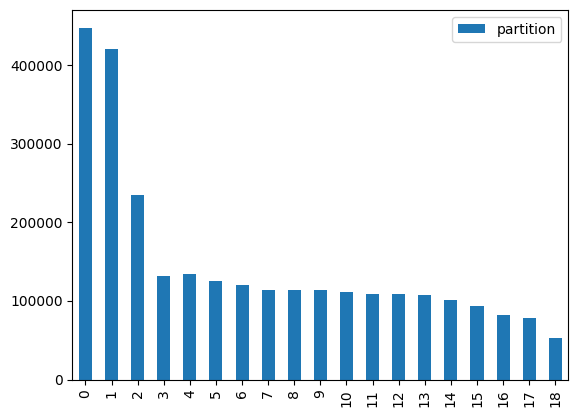

In [35]:
# Collect() results from all partitions back to driver
# WARNING: Computation heavy and memory intensive operation
def fetch_data_count_per_partition(partition):
    cnt = 0
    for _ in partition:
        cnt+=1
    return [cnt]

r = duration_rdd.mapPartitions(fetch_data_count_per_partition).collect()
pd.DataFrame(r, columns=['partition']).plot(kind='bar')

Uneven distribution of data across partitions

In [36]:
# Repartition to fix uneven data distribution across partitions
duration_rdd = duration_rdd.repartition(20)   # Transformation
duration_rdd.take(1)                 # Action

[Row(VendorID=1, lpep_pickup_datetime=datetime.datetime(2020, 1, 2, 8, 15, 51), PULocationID=173, DOLocationID=226, trip_distance=5.1)]

<Axes: >

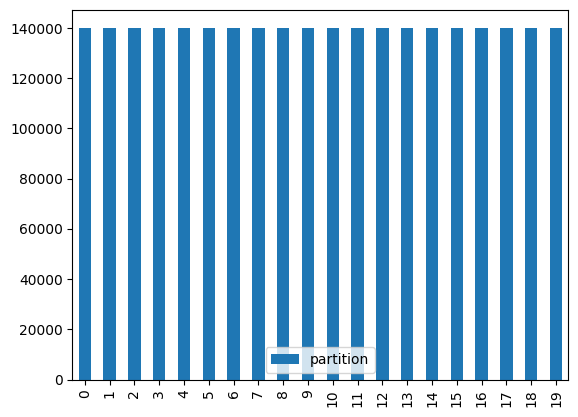

In [38]:
# Re-check distribution
r = duration_rdd.mapPartitions(fetch_data_count_per_partition).collect()
pd.DataFrame(r,columns=['partition']).plot(kind='bar')

In [ ]:
# #model = ...

# def model_predict(df):
# #     y_pred = model.predict(df)
#     y_pred = df.trip_distance * 5
#     return y_pred

In [ ]:
def fetch_count(rows):
    df = pd.DataFrame(rows, columns=columns) # convert each partition into pd dataframe
    cnt = len(df) # Calculate number of rows
    return [cnt] # return number of rows

<Axes: >

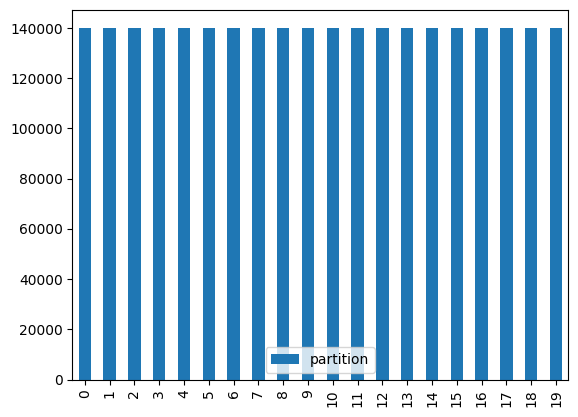

In [ ]:
r = duration_rdd.mapPartitions(fetch_count).collect()
pd.DataFrame(r,columns=['partition']).plot(kind='bar')

In [51]:
model = ... # Ellipsis operator, similar to `pass` to act as placeholder

def model_predict(df):
    # y_pred = model.predict(df)
    y_pred = df.trip_distance * 5
    return y_pred

def apply_model_in_batch(rows):
    df = pd.DataFrame(rows, columns=columns)

    # Spark doesnt recognize pandas Timestamp, casting it to string so spark can infer
    df['lpep_pickup_datetime'] = df['lpep_pickup_datetime'].astype(str) # string conversion

    predictions = model_predict(df)
    df['predicted_duration'] = predictions

    # itertuples converts dataframe into an iterator where each row is a namedtuple Pandas()
    for row in df.itertuples():
        yield row

In [52]:
duration_rdd.mapPartitions(apply_model_in_batch).take(10)

[Pandas(Index=0, VendorID=1, lpep_pickup_datetime='2020-01-02 08:15:51', PULocationID=173, DOLocationID=226, trip_distance=5.1, predicted_duration=25.5),
 Pandas(Index=1, VendorID=2, lpep_pickup_datetime='2020-01-28 06:58:23', PULocationID=7, DOLocationID=223, trip_distance=0.97, predicted_duration=4.85),
 Pandas(Index=2, VendorID=2, lpep_pickup_datetime='2020-01-18 21:31:48', PULocationID=181, DOLocationID=177, trip_distance=4.55, predicted_duration=22.75),
 Pandas(Index=3, VendorID=2, lpep_pickup_datetime='2020-01-31 20:29:04', PULocationID=7, DOLocationID=179, trip_distance=0.59, predicted_duration=2.9499999999999997),
 Pandas(Index=4, VendorID=2, lpep_pickup_datetime='2020-01-11 15:51:53', PULocationID=166, DOLocationID=166, trip_distance=0.57, predicted_duration=2.8499999999999996),
 Pandas(Index=5, VendorID=2, lpep_pickup_datetime='2020-01-04 21:25:03', PULocationID=95, DOLocationID=129, trip_distance=6.79, predicted_duration=33.95),
 Pandas(Index=6, VendorID=2, lpep_pickup_datet

In [ ]:
df_predicts = (
    duration_rdd 
    .mapPartitions(apply_model_in_batch)
    .toDF() 
    .drop('Index')
)
df_predicts.show(10)

+--------+--------------------+------------+------------+-------------+------------------+
|VendorID|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|predicted_duration|
+--------+--------------------+------------+------------+-------------+------------------+
|       1| 2020-01-02 08:15:51|         173|         226|          5.1|              25.5|
|       2| 2020-01-28 06:58:23|           7|         223|         0.97|              4.85|
|       2| 2020-01-18 21:31:48|         181|         177|         4.55|             22.75|
|       2| 2020-01-31 20:29:04|           7|         179|         0.59|2.9499999999999997|
|       2| 2020-01-11 15:51:53|         166|         166|         0.57|2.8499999999999996|
|       2| 2020-01-04 21:25:03|          95|         129|         6.79|             33.95|
|       2| 2020-01-13 18:21:26|         260|         157|         1.11| 5.550000000000001|
|       2| 2020-01-07 10:47:54|          52|          33|         0.62|               3.1|

In [65]:
from pyspark.sql import functions as F

# Apply round transformation
df_predicts = (
    df_predicts
    .withColumn('predicted_duration', F.round(df_predicts['predicted_duration']))
)
df_predicts.orderBy('predicted_duration', ascending=False).select('predicted_duration').show()

+------------------+
|predicted_duration|
+------------------+
|         1671516.0|
|         1667873.0|
|         1661513.0|
|         1570995.0|
|         1534107.0|
|         1525143.0|
|         1517914.0|
|         1511482.0|
|         1509354.0|
|         1501563.0|
|         1501184.0|
|         1469657.0|
|         1463055.0|
|         1461422.0|
|         1435251.0|
|         1417467.0|
|         1408551.0|
|         1359106.0|
|         1358618.0|
|         1355464.0|
+------------------+
only showing top 20 rows

